# Merge Geovars
Merge all the geovariables and write results toCSV file and STATA
**Author:** <font color='blue'>Dunstan Matekenya</font> 

**Affiliation:** <font color='#F88379'>DECAT, The World Bank Group</font> 

**Date:** <span style="color:#3EACAD">August 4, 2023</span>

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import sys
from pathlib import Path
from IPython.display import Image, display
from matplotlib import pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

spanon = Path.cwd().parents[2].joinpath("Spatial-Anonymization/src/")
sys.path.insert(0, str(spanon))
from spatial_anonymization import utils
from spatial_anonymization import point_displacement
import rasterio
from rasterstats import gen_zonal_stats

In [2]:
# =============================
# BASE WORKING DIRS
# ============================
DIR_DATA = Path.cwd().parents[1].joinpath('data')
DIR_SPATIAL = Path.cwd().parents[1].joinpath('data', 'TZA', 'spatial')
DIR_NPS_W4 = DIR_DATA.joinpath('TZA', 'surveys', 'NPS_w4')
DIR_NPS_W5 = DIR_DATA.joinpath('TZA', 'surveys', 'NPS_w5')
DIR_OUTPUTS = DIR_NPS_W5.joinpath('geovars', 'puf')

# =============================
# SURVEY COORDINATES 
# ============================
# WAVE-4 coordinates-public
FILE_PUB_HH_W4 = DIR_NPS_W4.joinpath('geovars', 'npsy4.ea.offset.dta')
FILE_W4_TMP = DIR_NPS_W4.joinpath('geovars', 'hh_sec_a.dta')

# WAVE-4 coordinates-raw
FILE_HH_W4 = DIR_NPS_W4.joinpath('geovars', 'HH_SEC_GPS.dta')

# WAVE-5 coordinates-raw
FILE_HH_W5 = DIR_NPS_W5.joinpath('survey', 'HH_SEC_GPS.dta')

# WAVE-5 FROM MICRODATA-LIB
FILE_HH_W5_MICROLIB = DIR_NPS_W5.joinpath( 'survey', 'from-microdata-lib', 'hh_sec_a.dta')

# ========================
# ADM FILES
# ========================
# Admin regions (adm2) shapefile
FILE_ADM3 = DIR_SPATIAL.joinpath("wards2012", "TZwards-wgs84.shp")

# ============================
# OTHER FILES
# ==================
FILE_POP20 =  DIR_DATA.joinpath('WORLDPOP', 'tza', 'tza_ppp_2020.tif')
FILE_WATER_BODIES =  DIR_SPATIAL.joinpath('waterbodies_wgs84.shp')

In [3]:
# ====================
# INPUT DATA SPECS
# =====================
# Cols for input coordinates file
LAT_W5 = 'lat_w5' 
LON_W5 = 'lon_w5'

LAT_PUB_W4 = 'lat_pub_w4' 
LON_PUB_W4 = 'lon_pub_w4'

LAT_PUB_W5 = 'lat_pub_w5' 
LON_PUB_W5 = 'lon_pub_w5'

LAT_W4 = 'lat_w4' 
LON_W4 = 'lon_w4'

LAT_W4_CENTROID = 'lat_cntr_w4' 
LON_W4_CENTROID = 'lon_cntr_w4'

LAT_W5_CENTROID = 'lat_cntr_w5' 
LON_W5_CENTROID = 'lon_cntr_w5'

HHID_W5 = 'y5_hhid'
HHID_W4 = 'y4_hhid'

CLUSTID_W4 = 'y4_clusterid'
CLUSTID_W5 = 'y5_clusterid'

URB_RURAL = 'y5_clustertype'

## Preprocess Data
### Notes
- Survey identifiers. Prefix **Y** and **W** are used interchangeably  to refer to survey NPS survey wave
- Y4 was conducted in 2014-2015
- Y5 was conducted in 2020-2021
- **HH** refers to Household while **HHs** is plural
- Binary variables. For most cases, 1->positive (yes) while 0->negative(no)

### Helper variables for coordinates review and mover detection
The following variables were generated.
1. **Y4 and Y5 Cluster centroids.** ```'lat_cntr_w4', 'lon_cntr_w4', 'lat_cntr_w5', 'lon_cntr_w5'```. Simply means of the coordinates when grouped by clusterid. **[Exclude some HHs which are too far (e.g., 10km) from the centroid]**
2. **Distance to Y4 households [dist_hh_y4].** Calculated for all household coordinates in Y5, this is distance to corresponding Y4 coordinates and so we expect ~ 0 for HHs which haven't moved.
3. **Distance to nearest clucter centroid [nearest_y4centroid].** Note that the cluster centroids are defined as in 1 above. This is also calculated for all HHs. For booster sample HHs, we assign them cluster based on nearest centroid.
4. **Nearest cluster [nearest_clusterid_y4].** Captures HH nearest based on HH coordinates and clusters centroids. It can be used to compare this clusterid with assigned cluster to check reliability of GPS coordinates.
5. **assigned_vs_nearest_clustid**. Compares whether the assigned clusterid is same as the nearest clusterid (as defined in 4 above)
5. **Y4 vs. Y5 clusterid[same_clust].**. Check whether HH has same clusterid in Y4 and Y5 again for sanity checks and mover detection.
6. **Imputed coordinates[y4_imputed_coords/y5_imputed_coords].** For data provenance purpose, indicate which HHs are using imputed coordinates.
6. **Additional HHs in Y5 [y5_add_hhs]**. For a Y4 HH, this variable indicates how many additional HHs are there in Y5. When ```y5_add_hhs = 0``` it means this household has no split HHs. This maybe useful for mover detection.

### Imputing missing coordinates
- Y4 missing coordinates are replaced with Y4 cluster centroids```lat_cntr_w4', lon_cntr_w4```
- Y5 missing coordinates are replaced with Y5 cluster centroids```lat_cntr_w5', lon_cntr_w5```

### Mover detection notes
#### Variables for mover assignment
- **Clusterid for mover HHs.** Its noted that mover households were not assigned a new clusterid (see screesnhot below) even though they moved as evidenced by variable ```same_clust```
- **Distance threshold for mover.** If a Y5 HHs is 5km or more from Y4 HHs and/or Y4-clustercentroid, then its a mover.
- **Variables for detecting movers.** 
    - Distance variables: ```dist_hh_y4``` and ```nearest_y4centroid``` where the distance threshold is applied.
    - Survey tracking status. The survey has variable tracking with the following possible values: 
    > 'ORIGINAL', 'LOCAL SPLIT-OFF MEMBER(S)', 'DISTANCE SPLIT-OFF MEMBER(S)', 'DISTANCE HOUSEHOLD', 'BOOSTER SAMPLE (NEW HOUSEHOLD)'
    - assigned_vs_nearest_clustid - Thiis is used to determine how much to trust/not trust coordinates
    - imputed_coordinates - Again this variable is used to assign level of trust
#### Mover status assignment
Please see function ```assign_mover_status(row)```. However, the summary process is shown in screenshot below:
The output variable **mover** has 4 possible integer values as follows:
 > 3-certain this is amover, 2-mover but with reduced confidence, 1-mover but with reduced confidence, 0- Non-mover
 For now, categories 1 and above are considered movers. However, category-1 may need review to decide whether to trust the HHs coordinates or not.

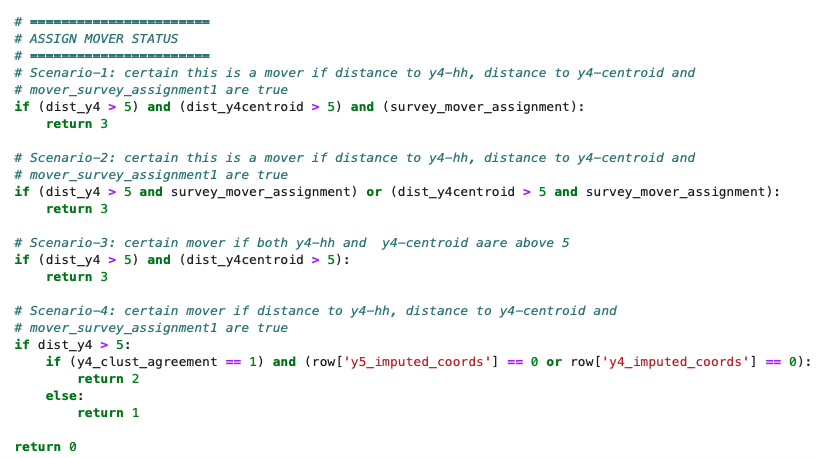

In [4]:
display(Image(filename='../../docs/images/tza-npsy5-mover-assignment.png'))

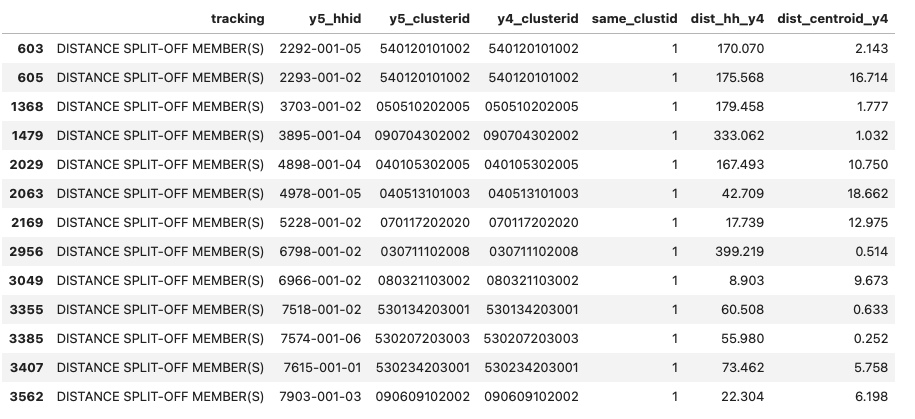

In [5]:
display(Image(filename='../../docs/images/tza-npsy5-movers-clusterid.png'))

In [8]:
def assign_mover_status(row):
    
    # ================================================
    # COLLECT VARIABLES TO USE TO DECIDE MOVER STATUS
    # ================================================
    # Distance from y5 to y4 HH rounded to integer
    dist_y4 = round(row['dist_hh_y4'], 0)
    
    # Distance from y5 to y4 centroid
    dist_y4centroid =  round(row['dist_centroid_y4'], 0)
    
    # Tracking status
    tracking_status = row['tracking']
    
    # Whether nearest cluster is same as assigned cluster
    y4_clust_agreement = row['assigned_vs_nearest_clustid']
    
    # If tracking_status is any of this, we consider HH a mover
    movers = ['LOCAL SPLIT-OFF MEMBER(S)', 'DISTANCE SPLIT-OFF MEMBER(S)', 'DISTANCE HOUSEHOLD']
    
    # Mover status based on "tracking_status" variable
    # This is given first precedence
    if tracking_status in movers:
        survey_mover_assignment = True
    else:
        survey_mover_assignment = False
    
    
    # =======================
    # ASSIGN MOVER STATUS
    # =======================
    # Scenario-1: certain this is a mover if distance to y4-hh, distance to y4-centroid and 
    # mover_survey_assignment1 are true
    if (dist_y4 > 5) and (dist_y4centroid > 5) and (survey_mover_assignment):
        return 3
    
    # Scenario-2: certain this is a mover if distance to y4-hh, distance to y4-centroid and 
    # mover_survey_assignment1 are true
    if (dist_y4 > 5 and survey_mover_assignment) or (dist_y4centroid > 5 and survey_mover_assignment):
        return 3

    # Scenario-3: certain mover if both y4-hh and  y4-centroid aare above 5
    if (dist_y4 > 5) and (dist_y4centroid > 5):
        return 3
    
    # Scenario-4: certain mover if distance to y4-hh, distance to y4-centroid and 
    # mover_survey_assignment1 are true
    if dist_y4 > 5:
        if (y4_clust_agreement == 1) and (row['y5_imputed_coords'] == 0 or row['y4_imputed_coords'] == 0):
            return 2
        else:
            return 1
    
    return 0

In [9]:
def load_and_preprocess_w4_files():
    """
    Do the following preprocessing
    1. Merge all multiple files into 1
    2. Check for extreme and/or outlier coordinates 
    2. Replace missing values (if any) with cluster centroids
    """
    # ===========================================
    # LOAD ALL THE FILES WE NEED
    # ===========================================
    df_w4_pub = pd.read_stata(FILE_PUB_HH_W4)
    df_w4_raw = pd.read_stata(FILE_HH_W4)
    df_w4_tmp = pd.read_stata(FILE_W4_TMP)
    df_w4_tmp['clusterid'] = df_w4_tmp['clusterid'].apply(lambda x: str(int(x)))
    df_w4_pub['clusterid'] = df_w4_pub['clusterid'].apply(lambda x: str(int(x)))
    
    tmp = df_w4_tmp.merge(df_w4_pub[['clusterid', 'lat_modified', 'lon_modified']], on='clusterid')
    assert len(tmp) == len(df_w4_raw)
    df_w4 = df_w4_raw.merge(tmp[['clusterid', 'clustertype', 'lat_modified', 'lon_modified', 'y4_hhid']], on=HHID_W4)
    
   
    # =====================
    # DO SOME CLEAN-UP
    # =====================
    # Change DMS to decimal degrees in df_w4_raw
    df_w4[LAT_W4] = df_w4.apply(lambda x: -round(x['hh_u1_lat_d'] + x['hh_u1_lat_md']/60, 6), axis=1)
    df_w4[LON_W4] = df_w4.apply(lambda x: round(x['hh_u1_lon_d'] + x['hh_u1_lon_md']/60, 6), axis=1)
    
    # Rename columns and keep only those we need
    df_w4.rename(columns={'lat_modified':LAT_PUB_W4, 'lon_modified':LON_PUB_W4, 'clusterid':CLUSTID_W4, 'clustertype': 'y4_clustertype'}, inplace=True)
    df_w4 = df_w4[['y4_hhid',  CLUSTID_W4, 'y4_clustertype', 'lat_pub_w4', 'lon_pub_w4', 'lat_w4', 'lon_w4']]
    
    # Format HHID and clusterid
    # Ensure HHID is a string
    df_w4[HHID_W4] = df_w4[HHID_W4].astype(str)
    
    # Padd zero to clusterid
    df_w4[CLUSTID_W4] = df_w4[CLUSTID_W4].apply(lambda x: '0{}'.format(x) if len(str(x))==11 else str(x))
    
    # ========================================
    # DEAL WITH MISSING AND EXTREME VALUES
    # ========================================
    lon_missing = df_w4[LON_W4].isna().sum()
    lat_missing = df_w4[LAT_W4].isna().sum()
    # Print missing values 
    print('='*35)
    print('Y4-MISSING COORDINATES REPORT')
    print('='*35)
    print(df_w4[[LON_W4, LAT_W4]].isna().sum())
    print('-'*35)
    print(df_w4[df_w4[LON_W4].isna()][['y4_hhid',  CLUSTID_W4, 'lat_w4', 'lon_w4']])
    
    # Print Lat and Lon ranges
    print()
    print('='*35)
    print('Y4-CHECKING RANGE OF COORDINATES')
    print('='*35)
    print(df_w4[[LAT_W4, LON_W4]].describe())
    print('-'*35)
    
    # ====================================
    # ADD WAVE-4 CLUSTER CENTROIDS
    # ====================================
    # add wave-4 coordinates cluster centroids
    df_clust = df_w4.groupby(CLUSTID_W4).agg({LAT_W4: 'mean', LON_W4:'mean'}).reset_index()
    df_clust.rename(columns = {LAT_W4: LAT_W4_CENTROID, LON_W4: LON_W4_CENTROID}, inplace=True)
    df_w4 = df_w4.merge(df_clust, on=CLUSTID_W4, how='left')
    assert df_w4[LAT_W4_CENTROID].nunique() == len(df_w4_pub)
   
    # Save cluster centroids as shapefile
    gdf_clust = gpd.GeoDataFrame(df_clust, geometry=gpd.points_from_xy(df_clust[LON_W4_CENTROID], df_clust[LAT_W4_CENTROID]), 
                                 crs="EPSG:4326")
    gdf_clust.to_file(DIR_SPATIAL.joinpath('y4-clust-centroids.shp'), driver='ESRI Shapefile')
    
    
    print('='*62)
    print('Y4: REPLACING MISSING COORDS WITH CLUSTER CENTROID IN {} HHs'.format(lon_missing))
    print('='*62)
    
    df_w4['y4_imputed_coords'] = df_w4[LAT_W4].apply(lambda x: 1 if np.isnan(x) else 0)
    df_w4[LAT_W4] = df_w4.apply(lambda x: x[LAT_W4_CENTROID] if np.isnan(x[LAT_W4]) else x[LAT_W4], axis=1)
    df_w4[LON_W4] = df_w4.apply(lambda x: x[LON_W4_CENTROID] if np.isnan(x[LON_W4]) else x[LON_W4], axis=1)
    print(df_w4.query('y4_imputed_coords == 1')[['y4_hhid',  CLUSTID_W4, 'lat_w4', 'lon_w4',LON_W4_CENTROID, LAT_W4_CENTROID]])
    
    assert df_w4[LON_W4].isna().sum() == 0
    assert df_w4[LAT_W4].isna().sum() == 0
    assert df_w4.y4_imputed_coords.value_counts()[1] == lon_missing, 'FILLED VLAUES SHOULD MATCH THOSE MISSING'
    assert df_w4.y4_imputed_coords.value_counts()[1] == lat_missing, 'FILLED VLAUES SHOULD MATCH THOSE MISSING'
    
    return df_w4

In [10]:
def load_and_preprocess_w5_files():
    """
    Do the following preprocessing
    1. Merge all multiple files into 1
    2. Check for extreme and/or outlier coordinates 
    2. Replace missing values (if any) with cluster centroids
    """
    
    # HHS with raw coordinates
    df_w5 = pd.read_stata(FILE_HH_W5)
    
    # HHS with cluster id
    df_w5_pub = pd.read_stata(FILE_HH_W5_MICROLIB)
    
    # =====================
    # DO SOME CLEAN-UP
    # =====================
    # Format clusterid: Padd zero to clusterid from y4 and remove "-" from y5 cluster 
    df_w5_pub[CLUSTID_W5] = df_w5_pub['y5_cluster'].apply(lambda x: x.replace("-", ""))
    assert df_w5_pub[CLUSTID_W5].isna().sum() == 0, 'THERE SHOULD BE NO NULLS FOR CLUSTERID'
    
    # Merge the two dataframes
    df_w5 = df_w5_pub[['y5_hhid', 'y5_rural',  CLUSTID_W5]].merge(df_w5[['y5_hhid', 'hh_gps__Latitude',
       'hh_gps__Longitude', 'hh_a10', 'tracking_class', 'booster']], on=HHID_W5)
    
    df_w5.rename(columns={'hh_gps__Longitude':LON_W5, 'hh_gps__Latitude':LAT_W5, 'y5_rural': URB_RURAL,
                          'tracking_class': 'tracking', 'booster': 'booster'}, inplace=True)
    
    # Add y4-hhid
    df_w5[HHID_W4] = df_w5[HHID_W5].apply(lambda x: x[:-3])
    
    # Ensure clustertype/urban/rural isnt doesnt have nulls
    assert df_w5[URB_RURAL].isna().sum() == 0,' URBAN-RURAL COLUMN SHOULDNT HAVE NULLS'
    
    
    # ========================================
    # DEAL WITH MISSING AND EXTREME VALUES
    # ========================================
    lon_missing = df_w5[LON_W5].isna().sum()
    lat_missing = df_w5[LAT_W5].isna().sum()
    # Print missing values 
    print('='*35)
    print('Y5-MISSING COORDINATES REPORT')
    print('='*35)
    print(df_w5[[LON_W5, LAT_W5]].isna().sum())
    print('-'*35)
    print(df_w5[df_w5[LON_W5].isna()][[HHID_W5,  CLUSTID_W5, LAT_W5, LON_W5, 'tracking']])
    
    # Print Lat and Lon ranges
    print()
    print('='*35)
    print('Y5-CHECKING RANGE OF COORDINATES')
    print('='*35)
    print(df_w5[[LAT_W5, LON_W5]].describe())
    print('-'*35)
    
    # ====================================
    # ADD WAVE-5 CLUSTER CENTROIDS
    # ====================================
    # add wave-4 coordinates cluster centroids
    df_clust = df_w5.groupby(CLUSTID_W5).agg({LAT_W5: 'mean', LON_W5:'mean'}).reset_index()
    df_clust.rename(columns = {LAT_W5: LAT_W5_CENTROID, LON_W5: LON_W5_CENTROID}, inplace=True)
    df_w5 = df_w5.merge(df_clust, on=CLUSTID_W5, how='left')
    assert df_w5[LAT_W5_CENTROID].nunique() == len(df_clust)
   
    # Save cluster centroids as shapefile
    gdf_clust = gpd.GeoDataFrame(df_clust, geometry=gpd.points_from_xy(df_clust[LON_W5_CENTROID], df_clust[LAT_W5_CENTROID]), 
                                 crs="EPSG:4326")
    gdf_clust.to_file(DIR_SPATIAL.joinpath('y5-clust-centroids.shp'), driver='ESRI Shapefile')
    
    print('='*62)
    print('Y5: REPLACING MISSING COORDS WITH CLUSTER CENTROID IN {} HHs'.format(lon_missing))
    print('='*62)
    
    df_w5['y5_imputed_coords'] = df_w5[LAT_W5].apply(lambda x: 1 if np.isnan(x) else 0)
    df_w5[LAT_W5] = df_w5.apply(lambda x: x[LAT_W5_CENTROID] if np.isnan(x[LAT_W5]) else x[LAT_W5], axis=1)
    df_w5[LON_W5] = df_w5.apply(lambda x: x[LON_W5_CENTROID] if np.isnan(x[LON_W5]) else x[LON_W5], axis=1)
    print(df_w5.query('y5_imputed_coords == 1')[['y5_hhid',  CLUSTID_W5, 'lat_w5', 'lon_w5',LON_W5_CENTROID, LAT_W5_CENTROID]])
    
    assert df_w5[LON_W5].isna().sum() == 0
    assert df_w5[LAT_W5].isna().sum() == 0
    assert df_w5.y5_imputed_coords.value_counts()[1] == lon_missing, 'FILLED VLAUES SHOULD MATCH THOSE MISSING'
    assert df_w5.y5_imputed_coords.value_counts()[1] == lat_missing, 'FILLED VLAUES SHOULD MATCH THOSE MISSING'
    
    return df_w5


In [18]:
def preprocess_coords(df_w4, df_w5):
    """
    Perform the following preprocessing steps:
    1. Merge w4 and w5 
    2. Add distance variables between w4 and w5 panel households (movers and non-movers)
    3. Add distance to nearest household for booster samples
    4. Assign mover status
    """
    # =====================
    # MERGE W5 WITH W4
    # =====================
    df_w5w4 = df_w5.merge(df_w4[['y4_hhid', CLUSTID_W4, 'lat_pub_w4', 'lon_pub_w4', 'y4_clustertype',
       'lat_w4', 'lon_w4', 'lat_cntr_w4', 'lon_cntr_w4', 'y4_imputed_coords']], on=HHID_W4, how='left', indicator=True)
    df_w5_booster_hhs = df_w5.query('booster == "New (booster) sample"')
    print(df_w5w4._merge.value_counts())
    assert len(df_w5_booster_hhs) == df_w5w4._merge.value_counts()['left_only'], 'MISMATCHED HHS SHOULD BE SAME AS BOOSTER HHS'
    df_w5 = df_w5w4.drop(columns=['_merge'])
    
    # =========================
    # CONVERT VARS TO NUMERIC
    # ========================
    df_w5['booster'] = df_w5.booster.map({'Panel household': 0, 'New (booster) sample': 1})

    df_w5 = df_w5[[HHID_W4, HHID_W5, CLUSTID_W5, CLUSTID_W4, URB_RURAL, 'y4_clustertype', 'lat_w5', 'lon_w5',  
           'lat_pub_w4', 'lon_pub_w4', 'lat_w4', 'lon_w4', LON_W5_CENTROID, 
            LAT_W5_CENTROID, 'tracking', 'booster', 'y4_imputed_coords', 'y5_imputed_coords']]
    
    # =================================
    # ADD DISTANCE VARS
    # =================================
    # Cluster level dataframe
    df_clust_y4 = df_w4[[CLUSTID_W4, LON_W4_CENTROID, LAT_W4_CENTROID]].drop_duplicates(subset=[CLUSTID_W4])
    assert len(df_clust_y4) == 419, 'THERE SHOULD BE 419 CLUSTERS'
    
    # Distance to nearest y4-cluster centroid
    df_w5['dist_centroid_y4'] = df_w5.apply(lambda x: utils.distance_to_points(
        df_clust_y4, (x[LAT_W5],x[LON_W5]), lon_col=LON_W4_CENTROID,lat_col=LAT_W4_CENTROID, output='nearest'), axis=1)
    
    # Nearest y4 clusterid based on distance to nearest centroid
    df_w5['nearest_clusterid_y4'] = df_w5.apply(lambda x: utils.distance_to_points(
        df_clust_y4, (x[LAT_W5],x[LON_W5]), lon_col=LON_W4_CENTROID,lat_col=LAT_W4_CENTROID, id_col=CLUSTID_W4, output='nearest_id'), axis=1)
    
    # Distance from y5 to corresponding y-4 hh
    df_w5['dist_hh_y4'] = df_w5.apply(lambda x: utils.distance_between_points((x[LON_W4], x[LAT_W4]), (x[LON_W5], x[LAT_W5])) if x['booster'] == 0 else np.NaN, axis=1)
    
    # =================================
    # ADD MOVER CHECKER VARS
    # =================================
    df_w5['same_clustid'] =  df_w5.apply(lambda x: 1 if x[CLUSTID_W5] == x[ CLUSTID_W4] else 0, axis=1)
    df_w5['assigned_vs_nearest_clustid'] =  df_w5.apply(lambda x: 1 if x[CLUSTID_W4] == x['nearest_clusterid_y4'] else 0, axis=1)
    
    df_w5_panel = df_w5.query('booster == 0')
    df_hh_cnt = pd.DataFrame(df_w5_panel.groupby(HHID_W4).size()).rename(columns={0:'y5_add_hhs'})
    df_panel = df_w5_panel.merge(df_hh_cnt, on=HHID_W4)
    df_panel['y5_add_hhs'] = df_panel['y5_add_hhs'] - 1
    assert len(df_panel) == len(df_w5_panel)
    
    df_w5_booster = df_w5.query('booster == 1')
    
    # ==================================
    # ADD MOVER STATUS TO PANEL HHS
    # ==================================
    df_panel['mover'] = df_panel.apply(lambda x: assign_mover_status(x), axis=1)
    assert df_panel['mover'].value_counts().sum() == len(df_panel), 'MOVER VARIABLE SHOULD HAVE NO NULLS'
    
    return df_panel, df_w5_booster

In [19]:
print('+'*40)
print('PROCESSING Y4 COORDINATES')
print('+'*40, '\n')
df_y4  = load_and_preprocess_w4_files()

print()
print('+'*40)
print('PROCESSING Y5 COORDINATES')
print('+'*40, '\n')
df_y5  = load_and_preprocess_w5_files()

df_w5_panel,  df_w5_booster = preprocess_coords(df_w4=df_y4, df_w5=df_y5)

++++++++++++++++++++++++++++++++++++++++
PROCESSING Y4 COORDINATES
++++++++++++++++++++++++++++++++++++++++ 

Y4-MISSING COORDINATES REPORT
lon_w4    16
lat_w4    16
dtype: int64
-----------------------------------
       y4_hhid  y4_clusterid  lat_w4  lon_w4
181   1425-001  070205202037     NaN     NaN
213   1499-001  070219204037     NaN     NaN
1600  4800-001  140313103006     NaN     NaN
1621  4843-001  140515101008     NaN     NaN
1664  4952-001  040403201002     NaN     NaN
1971  5696-001  070323207002     NaN     NaN
2010  5790-001  010410102002     NaN     NaN
2067  5926-001  250413304329     NaN     NaN
2107  6019-001  110305210004     NaN     NaN
2385  6683-001  030217102005     NaN     NaN
2514  6988-001  080510101004     NaN     NaN
2600  7194-001  120210101006     NaN     NaN
3027  8204-001  060508301305     NaN     NaN
3120  8429-001  170428102003     NaN     NaN
3155  8508-001  240121104003     NaN     NaN
3301  8853-001  140714103001     NaN     NaN

Y4-CHECKING RANGE O

In [21]:
df_w5_panel.assigned_vs_nearest_clustid.value_counts()

1    3373
0     791
Name: assigned_vs_nearest_clustid, dtype: int64

In [23]:
df_w5_panel.query('mover == 1')[['y4_hhid', 'y5_hhid', 'y5_clusterid', 'y4_clusterid', 'y5_clustertype',
       'y4_clustertype', 'lat_w5', 'lon_w5', 'lat_pub_w4', 'lon_pub_w4',
       'lat_w4', 'lon_w4', 'lon_cntr_w5', 'lat_cntr_w5', 'tracking', 'booster',
       'y4_imputed_coords', 'y5_imputed_coords', 'dist_centroid_y4',
       'nearest_clusterid_y4', 'dist_hh_y4', 'same_clustid',
       'assigned_vs_nearest_clustid', 'y5_add_hhs', 'mover']]

Index(['y4_hhid', 'y5_hhid', 'y5_clusterid', 'y4_clusterid', 'y5_clustertype',
       'y4_clustertype', 'lat_w5', 'lon_w5', 'lat_pub_w4', 'lon_pub_w4',
       'lat_w4', 'lon_w4', 'lon_cntr_w5', 'lat_cntr_w5', 'tracking', 'booster',
       'y4_imputed_coords', 'y5_imputed_coords', 'dist_centroid_y4',
       'nearest_clusterid_y4', 'dist_hh_y4', 'same_clustid',
       'assigned_vs_nearest_clustid', 'y5_add_hhs', 'mover'],
      dtype='object')

In [ ]:
df_w5_panel.

## Anonymize coordinates
Perform anonymzation as follows:
1. **Non-movers.** No anonymization required, assign y4 public coordinates
2. **Booster sample.** Apply anonymization as in a regular sample.
3. **Movers.** Apply anonymization at household level.

TO-DO
- For (2) and (3) above, generate ri

### Apply anonymization to the booster sample and movers

In [11]:
# =====================
# SETUP PARAMS 
# ====================
# urb_max_dist
urb_max = 2000
# rur_max_dist
rur_max = 5000
# rur_max_dist_subset
rur_max_subset = 10000
# urb_min_dist
urb_min = 0
# rur_min_dist
rur_min = 0
# apply_min_dist
apply_min_dist = False
# rur_subset_prop = 10%
rur_sub_prop = 0.1

# max_tries
max_tries = 25

# Maximum number of runs for a whole dataset of coordinates
max_runs = 10

# population threshold
pop_thres = 500

# setup the params dict
PARAMS = {'urb_max_dist': urb_max, 'rur_max_dist': rur_max, 'rur_max_dist_subset':rur_max_subset,
          'urb_min_dist': urb_min, 'rur_min_dist': rur_min, 'maximum_tries': max_tries,
          'apply_min_dist': apply_min_dist, 'rur_sub_prop': rur_sub_prop, 'admin_reg': 'adm3',
         'min_pop': pop_thres, 'max_runs': max_runs, 'utm_epsg_code': 32737}



# ===================================
# PREPARE PROCESSING ARGS AND INPUTS
# ==================================
# add EPSG code for geographic CRS if its not 
# default to WGS84
GEO_CRS = 4326
URB_RUR = URB_RURAL
RURAL_CODE = 'rural'

# put all input files into a dict
ANON_FILE_INPUTS = {'pop_tif': FILE_POP20, 'shp_waterbodies': FILE_WATER_BODIES,
                    'shp_adm_bounds': FILE_ADM3}

In [12]:
# =====================================
# APPLY ANONYMIZATION TO BOOSTER SAMPLE
# =====================================
# For this sample, run anonymization at cluster level
# input dataframe
df_input_booster = df_w5_booster[['y5_hhid', 'y5_clusterid', 'y5_clustertype',
       LON_W5_CENTROID, LAT_W5_CENTROID]].drop_duplicates(subset=['y5_clusterid'])

ANON_FILE_INPUTS['input_coords'] = df_input_booster.copy(deep=True)

# displacer object
displacer_booster = point_displacement.SimpleDisplacer(params=PARAMS, inputs=ANON_FILE_INPUTS, 
                                                       output_dir=DIR_OUTPUTS,lon_col=LON_W5_CENTROID, 
                                                       lat_col=LAT_W5_CENTROID, urb_rur_col=URB_RUR, 
                                                   unique_id=CLUSTID_W5, rural_code=RURAL_CODE, 
                                                  geodetic_crs=GEO_CRS)
# Run displacement
out_fpath_booster = DIR_OUTPUTS.joinpath("y5-booster-sample-disp.csv")
print('RUNNING DISPLACEMENT FOR BOOSTER SAMPLE ....')
print('-'*50)
print()
df_disp_booster = displacer_booster.run_displacer(output_file=out_fpath_booster)

RUNNING DISPLACEMENT FOR BOOSTER SAMPLE ....
--------------------------------------------------

 Running displacement with the following params
1.urb_max_dist-2000-Maximum distance(m) for anonymizing region for coordinates in urban areas
2.rur_max_dist-5000-Maximum distance(m) for anonymizing region for coordinates in rural areas
3.rur_max_dist_subset-10000-Maximum distance(m) for anonymizing region for a subset of coordinates in rural areas
4.urb_min_dist-0-Minimum distance(m) from original coordinates in urban areas
5.rur_min_dist-0-Minimum distance(m) from original coordinates in urban areas
6.maximum_tries-25-Number of times to keep trying when geenrated displaced coordinates do not meet requirements
7.apply_min_dist-False-Whether to apply minimum distance or not
8.rur_sub_prop-0.1-Proportion of rural cooridnates to apply large anonymizing zone
9.admin_reg-adm3-Admin region for constraining displaced coordinates
10.min_pop-500-Minimum number of people withing anonymizing region to

In [13]:
# =====================================
# APPLY ANONYMIZATION TO MOVERS
# =====================================
# For movers, apply anonymization at HH level using HH coordinates
# input dataframe
df_w5_panel_movers = df_w5_panel.query('mover > 0')[
    ['y5_hhid', 'y4_hhid', 'y5_clusterid', 'y5_clustertype', LAT_W5, LON_W5]]
ANON_FILE_INPUTS['input_coords'] = df_w5_panel_movers.copy(deep=True)

# displacer object
displacer_movers = point_displacement.SimpleDisplacer(params=PARAMS, inputs=ANON_FILE_INPUTS, 
                                                       output_dir=DIR_OUTPUTS,lon_col=LON_W5, 
                                                       lat_col=LAT_W5, urb_rur_col=URB_RUR, 
                                                   unique_id='y5_hhid', rural_code=RURAL_CODE, 
                                                  geodetic_crs=GEO_CRS)

# Run displacement
out_fpath_movers = DIR_OUTPUTS.joinpath("y5-movers-disp.csv")
print()
print('RUNNING DISPLACEMENT FOR MOVERS ....')
print('-'*60)
print()
df_disp_movers = displacer_movers.run_displacer(output_file=out_fpath_movers)


RUNNING DISPLACEMENT FOR MOVERS ....
------------------------------------------------------------

 Running displacement with the following params
1.urb_max_dist-2000-Maximum distance(m) for anonymizing region for coordinates in urban areas
2.rur_max_dist-5000-Maximum distance(m) for anonymizing region for coordinates in rural areas
3.rur_max_dist_subset-10000-Maximum distance(m) for anonymizing region for a subset of coordinates in rural areas
4.urb_min_dist-0-Minimum distance(m) from original coordinates in urban areas
5.rur_min_dist-0-Minimum distance(m) from original coordinates in urban areas
6.maximum_tries-25-Number of times to keep trying when geenrated displaced coordinates do not meet requirements
7.apply_min_dist-False-Whether to apply minimum distance or not
8.rur_sub_prop-0.1-Proportion of rural cooridnates to apply large anonymizing zone
9.admin_reg-adm3-Admin region for constraining displaced coordinates
10.min_pop-500-Minimum number of people withing anonymizing region

In [14]:
# df = pd.read_csv(DIR_OUTPUTS.joinpath('y5-movers-disp-failed.csv'))

### Merge back files and create final y5 public coordinates file
1. Add final tracking status column to show which households are panel-movers, panel-non-movers and booster
2. Merge all into a single dataframe
3. Ensure all households have public coordinates except for those which didnt get anonymized

In [93]:
# =========================================
# RENAME DISP_COORDS TO MATCH WITH COLNAMES 
# IN DF_W5_PANEL
# ========================================
df_disp_booster2 = df_disp_booster.rename(columns={'disp_lon': LON_PUB_W5,
                                                   'disp_lat': LAT_PUB_W5})[['y5_clusterid',LON_PUB_W5, LAT_PUB_W5]]

df_disp_movers2 = df_disp_movers[['y5_hhid', 'disp_lon','disp_lat']]

# =============================================
# MERGE CLUSTER LEVEL BOOSTER DATAFRAME WITH
# DISPACED COORDINATES WITH HH LEVEL DATAFRAME
# ============================================
df_w5_booster['tracking_final'] = 'booster'
df_w5_booster2 = df_w5_booster.merge(df_disp_booster2, on='y5_clusterid', how='left', indicator=True)
assert df_w5_booster2._merge.value_counts()['both'] == len(df_w5_booster)
df_w5_booster2.drop(columns=['_merge'], inplace=True)
assert df_w5_booster2[LON_PUB_W5].isna().sum() == 0
assert df_w5_booster2[LAT_PUB_W5].isna().sum() == 0

# ========================================
# MERGE MOVERS BACK TO DF_PANEL DATAFRAMES
# ========================================
# Add a variable (tracking_final) to indicate whether each HH
# is mover, non-mover or booster
df_w5_panel['tracking_final'] = df_w5_panel.mover.apply(lambda x: 'mover' if x > 0 else 'non-mover')

# For non-movers, we carry over the Y4 public coordinates
# as Y5 public coordinates
df_w5_panel[LON_PUB_W5] = df_w5_panel.apply(lambda x: x[LON_PUB_W4] if x['tracking_final'] == 'non-mover' else np.NaN, axis=1)
df_w5_panel[LAT_PUB_W5] = df_w5_panel.apply(lambda x: x[LAT_PUB_W4] if x['tracking_final'] == 'non-mover' else np.NaN, axis=1)

# Merge the movers dataframe with displaced coordinates 
# with the rest of the panel dataframe
df_w5_panel2 = df_w5_panel.merge(df_disp_movers2, on='y5_hhid', how='left', indicator=True)
assert df_w5_panel2._merge.value_counts()['both'] == len(df_disp_movers2)
df_w5_panel2[LON_PUB_W5] = df_w5_panel2.apply(lambda x: x['disp_lon'] if x['tracking_final'] == 'mover' else x[LON_PUB_W5], axis=1)
df_w5_panel2[LAT_PUB_W5] = df_w5_panel2.apply(lambda x: x['disp_lat'] if x['tracking_final'] == 'mover' else x[LAT_PUB_W5], axis=1)
df_w5_panel2.drop(columns=['_merge', 'disp_lon', 'disp_lat'], inplace=True)
assert df_w5_panel2[LON_PUB_W5].isna().sum() == 8
assert df_w5_panel2[LAT_PUB_W5].isna().sum() == 8

# ========================================
# MERGE ALL DATAFRAMES TOGETHER
# ========================================
# Append booster sample to panel sample
dfw5 = pd.concat([df_w5_panel2, df_w5_booster2], axis=0)

keep_cols = ['y5_hhid', 'y5_clusterid', 'y5_clustertype', 
       'tracking_final','lon_cntr_w5', 'lat_cntr_w5', LON_W5, LAT_W5,
       'lon_pub_w5', 'lat_pub_w5']

dfw5 = dfw5[keep_cols]
dfw5['make_public'] = dfw5.apply(lambda x: 0 if np.isnan(x[LON_PUB_W5]) else 1, axis=1)

assert len(dfw5) == df_w5_panel.shape[0] + df_w5_booster.shape[0]

# Save to CSV
out_csv = DIR_OUTPUTS.joinpath('y5-hhs-pub-coords.csv')
dfw5.to_csv(out_csv, index=False)

In [92]:
LON_W5

PosixPath('/Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG/DECAT_HH_Geovariables/data/TZA/surveys/NPS_w5/geovars/puf/y5-hhs-pub-coords.csv')

In [91]:
LON_PUB_W5

'lon_pub_w5'